# Processing A Single Exposure Image

In this tutorial, you will learn how to perform photometry on a single image. Before doing this tutorial, you should have watched the Introduction to Photometry video lecture. In this tutorial, you will 
1. Tutorial on displaying images
2. Read in a fits image and display it in Python
3. Calculate the background for the whole image
4. Subtract the background for the whole image
5. Count up the pixel values inside an aperture around a star
6. Calculate the magnitude of this star by using refernece star magnitudes in the image

You will be using many skills you learned in the PASEA Alumni Programming Python Workshops. Skills include reading in fits files, plotting and functional programming. 

This notebook requires installing the following Python modules. This should be set up already on the google co-lab platform. 
* pip install photutils
* pip install astropy
* pip install imageio

In [1]:
# Import statements

import warnings
warnings.filterwarnings('ignore')

import glob
import numpy as np

from photutils import Background2D, SExtractorBackground
from photutils import DAOStarFinder
from photutils import CircularAperture,aperture_photometry
from photutils.utils import calc_total_error

import astropy.wcs as wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.nddata.utils import Cutout2D
from astropy import units as u

import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

# 1. Tutorial on plotting images

An image is a 2D array of numbers. You can display a 2D array of numbers as an image using matplotlib.pyplot's imshow. 

The example below has pixel values mostly around 1-3, but one pixel value (lower left) is 1000. When you display it, the 1000 pixel will be displayed as white and because the rest of the pixels are so close together in value, they will all appear black. This is because the range between 1 and 1000 is evenly assigned colours black to white in an even gradient. 

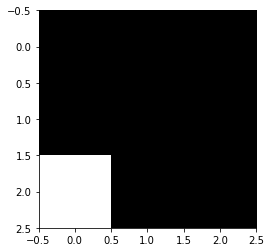

In [6]:
simple_image = [[1.,2.,1.3],
                [1.9,2.3,1.8],
                [1000,2.1,1.4]]
plt.imshow(simple_image, cmap='gray')

What if we want to see the variation in pixel value of the pixels with values 1-3? We can ask imshow to plot all pixels brighter than 3 as white and all pixels fainter than 1 as black. This way, only the pixel values between 1 and 3 will need to be assigned colours black to white with an even gradient.  

Notice below the top left pixel value is 1, and it is black and the bottom left pixel value is 1000 and it is white. 

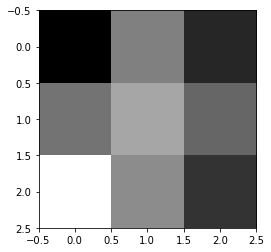

In [7]:
simple_image = [[1.,  2., 1.3],
                [1.9, 2.3,1.8],
                [1000,2.1,1.4]]

plt.imshow(simple_image,vmin=1, vmax=3, cmap='gray')

## Exercises

Try plotting the below image and setting your own vmax and vmin so that you see the following displayed for the simple_image defined below.
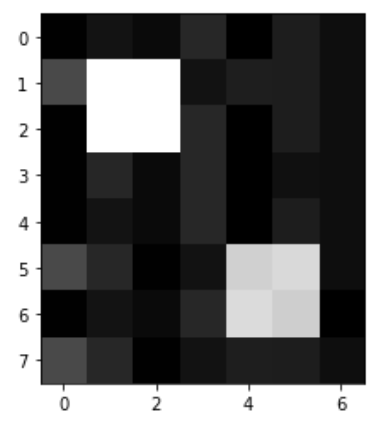

Also try plotting the image with a different cmap, which defines what the color to display the image. 

In [28]:
# You can do your exercise in this cell, as well as make extra cells. 

simple_image = [[1., 2., 1.5, 3.1, 0.9, 2.5, 1.7],
                [5., 976, 955, 1.9, 2.6, 2.5, 1.7 ],
                [1., 999, 985, 3.1, 0.9, 2.5, 1.7],
                [1., 3, 1.5, 3.1, 0.9, 1.8, 1.7],
                [1., 2., 1.5, 3.1, 0.9, 2.5, 1.7],
                [5., 3.1, 1., 1.9, 12.4, 12.9, 1.7],
                [1., 2., 1.5, 3.1, 13., 12.3, 0.9],
                [5., 3.1, 1., 1.9, 2.6, 2.5, 1.7]
               ]

# Exercise: display your image so it looks like the above



In [29]:
# You can do your exercise in this cell, as well as make extra cells. 

simple_image = [[1., 2., 1.5, 3.1, 0.9, 2.5, 1.7],
                [5., 976, 955, 1.9, 2.6, 2.5, 1.7 ],
                [1., 999, 985, 3.1, 0.9, 2.5, 1.7],
                [1., 3, 1.5, 3.1, 0.9, 1.8, 1.7],
                [1., 2., 1.5, 3.1, 0.9, 2.5, 1.7],
                [5., 3.1, 1., 1.9, 12.4, 12.9, 1.7],
                [1., 2., 1.5, 3.1, 13., 12.3, 0.9],
                [5., 3.1, 1., 1.9, 2.6, 2.5, 1.7]
               ]

# Exercise: display your image in a different color



There is a function that helps you set reasonable vmin and vmax values for any input image. Here is an exmaple of how to use it. 

In [30]:
simple_image = [[1., 2., 1.5, 3.1, 0.9, 2.5, 1.7],
                [5., 976, 955, 1.9, 2.6, 2.5, 1.7 ],
                [1., 999, 985, 3.1, 0.9, 2.5, 1.7],
                [1., 3, 1.5, 3.1, 0.9, 1.8, 1.7],
                [1., 2., 1.5, 3.1, 0.9, 2.5, 1.7],
                [5., 3.1, 1., 1.9, 12.4, 12.9, 1.7],
                [1., 2., 1.5, 3.1, 13., 12.3, 0.9],
                [5., 3.1, 1., 1.9, 2.6, 2.5, 1.7]
               ]

interval = ZScaleInterval()
vmin     = interval.get_limits(simple_image)[0]
vmax     = interval.get_limits(simple_image)[1]
print('vmin: ',vmin)
print('vmax: ',vmax)

# Exercise: Use this automatically determined vmin and vmax to display your image. 



vmin:  0.9
vmax:  8.613069828722004


# 2. Read in a fits image and display it in Python
First Define where the image you will analyse is located. 

In [2]:
# Set path to file
# This exposure was taken in the B-band. 
file_input   = '../Data/Target_A/B/coj0m403-kb97-20191006-0058-e91.fits.fz'
mypath       = './' 

Then open the fits file for the single image and display it

vmin:  235.64383
vmax:  415.25894


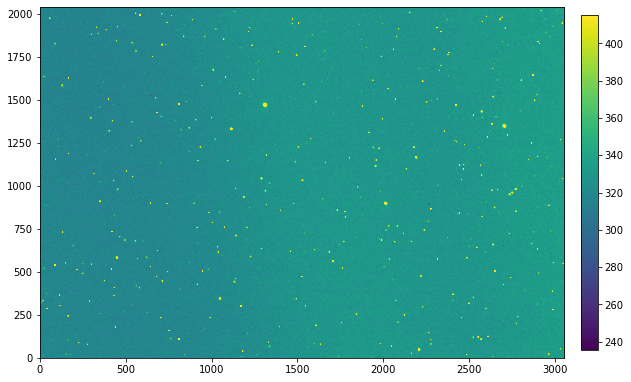

In [46]:
# Plot the whole image with the reference star and target star marked to see if it all looks ok

# Read in the data and the fits file header information
sci_data, sci_header   = fits.getdata(file_input,header=True)

# Get the best vmin and vmax to visualize the image
# See why these two values were picked using ds9. 
interval = ZScaleInterval()
vmin     = interval.get_limits(sci_data)[0]
vmax     = interval.get_limits(sci_data)[1]
print('vmin: ',vmin)
print('vmax: ',vmax)

figure = plt.figure(figsize=(10,22))
im = plt.imshow(sci_data, vmin=vmin, vmax=vmax, origin='lower')
plt.colorbar(im,fraction=0.03, pad=0.03)

# 3. Calculate the background for the whole image

To be able to measure the brightness of stars, first the sky background must be found and subtracted. Here we will estimate the background of every pixel in the image, then subtract it from the image to get a background subtracted image with which we can measure the brightness of stars. To estimate the background we will use a software called Source Extractor. 

In [36]:
# Sigma clip bright obvious things to avoid biasing the background estimate
sigma_clip    = SigmaClip(sigma=3.) 

# Apply the SExtractor algorithm to our estimation
bkg_estimator = SExtractorBackground() 
bkg           = Background2D(   sci_data, (50, 50),
                                filter_size=(3, 3),
                                sigma_clip=sigma_clip,
                                bkg_estimator=bkg_estimator )

# Now let's subtract the background from the data
# The background that Source Extractor calculated is stored in the variable bkg.background. 
sci_bkg = sci_data - bkg.background

## Exercise

Display the background image found above, i.e. bkg.background. You can use what you learned about displaying images in the "1. Tutorial on plotting images" above. 

vmin:  315.2470098222169
vmax:  335.9592823316951


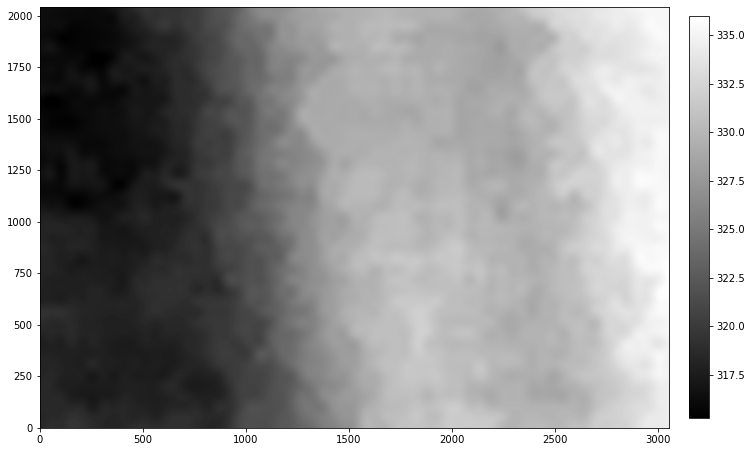

In [48]:
# Show the background to see what it looks like

interval = ZScaleInterval()
vmin = interval.get_limits(bkg.background)[0]
vmax = interval.get_limits(bkg.background)[1]
print('vmin: ',vmin)
print('vmax: ',vmax)

figure = plt.figure(figsize=(12,24))
im = plt.imshow(bkg.background, vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
plt.colorbar(im,fraction=0.03, pad=0.03)

# Details on target and reference stars

In [4]:
# Identify the star that you wanted to observe by opening the image in ds9 
# by finding the star with the matching RA and DEC
# Write down the RA and DEC of your target star here
# Check that the star is not saturated.

target_RA  = 299.18555
target_DEC = -1.0214

In [5]:
# By looking at one of the exposures in ds9, identify 4-8 round, 
# bright stars that are not saturated 
# to use as ref stars.
# Write down their RA, DEC below in a list

ref_ra  = [299.11433, 299.0763, 299.20659, 299.23568,299.25526]
ref_dec = [-0.84994178, -0.94528461, -1.1268563, -1.2084083,-0.98725623]

In [6]:
# Download the APASS catalog of this region of the sky from here: 
# https://www.aavso.org/apass-dr10-download
# Identify which sources on the APASS catalog match the RA and DEC of your selected reference stars
# Write down the magnitude of your selected reference stars below in a list

zpt_instrumental = 25.
ref_mag = [12.2291, 12.372, 12.119,9.939,9.246]

# Visualize image, target and refernece stars

### Visualize a single frame

vmin:  235.64383
vmax:  415.25894


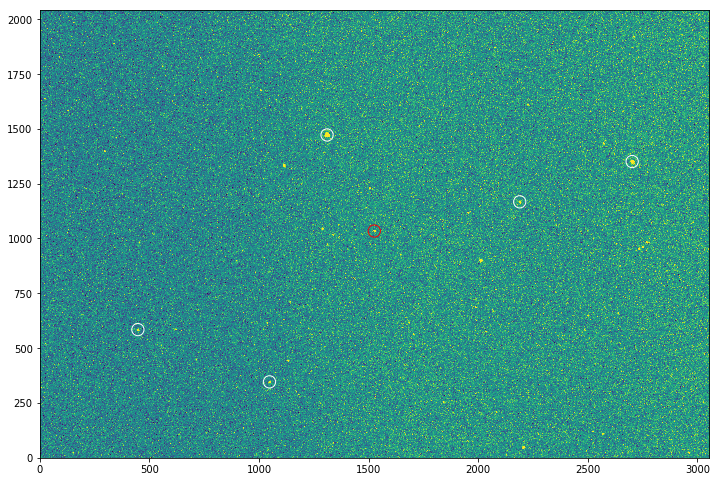

In [9]:
# Plot the whole image with the reference star and target star marked to see if it all looks ok

# Read in the data and the fits file header information
sci_data, sci_header   = fits.getdata(file_input,header=True)

# Determine where to mark the reference stars
w                            = wcs.WCS(sci_hdr)
xcoord_ref, ycoord_ref       = w.all_world2pix(ref_ra,ref_dec,1)
xcoord_target, ycoord_target = w.all_world2pix([target_RA],[target_DEC],1)

# Get the best vmin and vmax to visualize the image
# See why these two values were picked using ds9. 
interval = ZScaleInterval()
vmin     = interval.get_limits(sci_data.data)[0]
vmax     = interval.get_limits(sci_data.data)[1]
print('vmin: ',vmin)
print('vmax: ',vmax)

figure = plt.figure(figsize=(12,24))
plt.imshow(sci_data.data, vmin=vmin, vmax=vmax, origin='lower')
plt.scatter(xcoord_ref,ycoord_ref,marker='o',
            facecolors='none',s=150,linewidth=1,color='white')
plt.scatter(xcoord_target,ycoord_target,marker='o',
            facecolors='none',s=150,linewidth=1,color='red')

# Some useful functions

In [10]:
# A function that outputs the magnitude of a source, and its error.

def do_phot_get_mag(data,hdr,err,ra,dec):
    zpt_instrumental = 25.
    w         = wcs.WCS(hdr)
    xcoords, ycoords = w.all_world2pix(ra,dec,1)
    positions = np.transpose((xcoords, ycoords))
    apertures = CircularAperture(positions, r=24.)
    phot      = aperture_photometry(data, apertures, error=err)

    mag     = list(-2.5*np.log10(phot['aperture_sum']) + zpt_instrumental)
    mag_err = list((2.5/np.log(10))*(phot['aperture_sum_err']/phot['aperture_sum']))
    
    return mag,mag_err

In [11]:
# A function that outputs a small cutout of an image given a big image. 

def make_cutout(data,hdr,ra,dec):

    w = wcs.WCS(hdr)
    xcoord, ycoord = w.all_world2pix(ra,dec,1)
    position = np.transpose((xcoord, ycoord))
    size = u.Quantity([120, 120], u.pixel)
    cutout = Cutout2D(data, position, size, wcs=w, mode='strict')

    cutout_wcs = cutout.wcs
    header = cutout_wcs.to_header()
    hdu = fits.PrimaryHDU(data=cutout.data, header=header)

    return hdu

# Try to calcualte the magnitude of the target star in one frame. 

### 1. Open the frame and read out the data, header and time of observation

In [12]:
# Read in file
hdu = fits.open(file_input)

# Grab the actual science data based on above.
sci_data = hdu[1]
sci_hdr = sci_data.header
time = sci_hdr['MJD-OBS']

### Exercise

In [13]:
# Print the time of observation of this exposure


### 2. Get the background of the image and subtract it; Calculate the error associated with the background.

In [14]:
# Background estimation:
sigma_clip = SigmaClip(sigma=3.) # Sigma clip bright obvious things to avoid biasing the background estimate
bkg_estimator = SExtractorBackground() # Apply the SExtractor algorithm to our estimation
bkg = Background2D(
    sci_data.data, (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator)

# Now let's subtract the background from the data
sci_bkg = sci_data.data - bkg.background

# Define an error image that will be used when calculating photometry
effective_gain = 1.
error = calc_total_error(sci_bkg, bkg.background_rms, effective_gain)

### Exercise

vmin:  315.2469885473463
vmax:  335.9592711680875


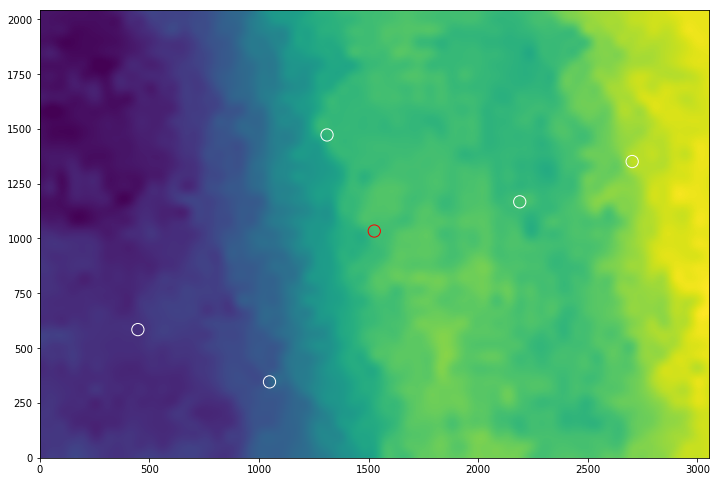

In [15]:
# Show the background to see what it looks like

interval = ZScaleInterval()
vmin = interval.get_limits(bkg.background)[0]
vmax = interval.get_limits(bkg.background)[1]
print('vmin: ',vmin)
print('vmax: ',vmax)

figure = plt.figure(figsize=(12,24))
plt.imshow(bkg.background, vmin=vmin, vmax=vmax, origin='lower')
plt.scatter(xcoord_ref,ycoord_ref,marker='o',
            facecolors='none',s=150,linewidth=1,color='white')
plt.scatter(xcoord_target,ycoord_target,marker='o',
            facecolors='none',s=150,linewidth=1,color='red')

### Exercise

In [16]:
# Show the background subtracted image and see what it looks like


### 3. For the target star and each reference star, carry out photometry. Be sure to use the background subtracted image. This step should output an error of the photmetry measurement. 

In [17]:
# Calculate instrumental mags for each of the reference stars
ref_instr_mag,ref_instr_mag_err = do_phot_get_mag(sci_bkg,sci_hdr,error,ref_ra,ref_dec)

# Do photometry on the variable target
tar_mag,tar_mag_err = do_phot_get_mag(sci_bkg,sci_hdr,error,target_RA,target_DEC)

### 4. Find the magnitude offset between the reference stars and the catalog magnitudes and calculate the magnitude of the target star, and its error. 

In [18]:
# Calculate offsets and the standard deviation of the offset from each star.
offsets = []
for i in range(len(ref_instr_mag)):
    offsets.append(ref_mag[i] - ref_instr_mag[i])
offset = np.mean(offsets)
offset_err = np.std(offsets)

cal_tar_mag = tar_mag[0]+offset
cal_tar_mag_err = np.sqrt(tar_mag_err[0]**2.+offset_err**2.)

### Exercise

In [19]:
# Print the magnitude of your target (saved under variable calibrated target magnitude: cal_tar_mag)



# Make a tiny cutout around the star

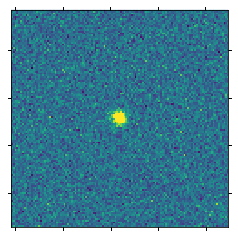

In [20]:
# Make tiny cutouts of the variable star in each frame
cutout_hdu = make_cutout(sci_bkg,sci_hdr,target_RA,target_DEC)
#cutout_hdu.writeto(frame+'_cutout.fits', overwrite=True)

# Plot figures using these cutouts and output images
interval = ZScaleInterval()
vmin = interval.get_limits(cutout_hdu.data)[0]
vmax = interval.get_limits(cutout_hdu.data)[1]

plt.subplot(projection=wcs.WCS(cutout_hdu.header))
plt.imshow(cutout_hdu.data, vmin=vmin, vmax=vmax, origin='lower')
plt.xlabel('R.A.')
plt.ylabel('Declination')

# Save the small cutout as a png, with the file name as the time of observation. 
# This can be used later to make a movie of your source
pngname = str(time).replace('.','')
plt.savefig(mypath+pngname+'.png', overwrite=True)